In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import scipy.optimize as opt
from scipy.stats import norm
from scipy.optimize import curve_fit
from tqdm.auto import trange
from tqdm import tqdm
import Metropolis_Algorithm as MA

import importlib

importlib.reload(MA)

C:\Users\sebas\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'Metropolis_Algorithm' from 'C:\\Users\\sebas\\Documents\\GitHub\\Sebastian_Sloan_Computational_Physics\\Metropolis_Algorithm.py'>

In [2]:
# Setting Constants
x_0 = 0
y_0 = 0
t_i = 0
t_f = 8

mass = 1
steps = 150  # Reduced from 800 - fewer points to update
numb_paths = 1000

times = np.linspace(t_i, t_f, steps)
dt = times[1] - times[0]

In [3]:
# Potential
def x_potential(x):
    return 1 / 2 * x ** 2


def y_potential(x):
    return 1000 * x ** 4


def ho_analytic_pdf(x):
    return (1 / np.sqrt(np.pi)) * np.exp(-x ** 2)


def residual_calculator1(x_values, model, model_parameters, y_values, y_errors):
    theoretical_values = model(x_values, *model_parameters)
    residuals = (y_values - theoretical_values) / y_errors
    return residuals

def residual_calculator2(theoretical_values, y_values, y_errors):
    residuals = (y_values - theoretical_values) / y_errors
    return residuals

# Propagator Data

In [4]:
# Setting Constants

#position boundaries
x_0_prop = 0
x_endpoints_prop = np.linspace(-2, 2, 201)

#time boundaries
t_i_prop = 0
t_f_prop = 6

#other constants
mass_prop = 1
steps_prop = 7
numb_paths_prop = 1000

#array of times
times_prop = np.linspace(t_i_prop, t_f_prop, steps_prop)
dt_prop = times_prop[1] - times_prop[0]
print(x_endpoints_prop)

[-2.   -1.98 -1.96 -1.94 -1.92 -1.9  -1.88 -1.86 -1.84 -1.82 -1.8  -1.78
 -1.76 -1.74 -1.72 -1.7  -1.68 -1.66 -1.64 -1.62 -1.6  -1.58 -1.56 -1.54
 -1.52 -1.5  -1.48 -1.46 -1.44 -1.42 -1.4  -1.38 -1.36 -1.34 -1.32 -1.3
 -1.28 -1.26 -1.24 -1.22 -1.2  -1.18 -1.16 -1.14 -1.12 -1.1  -1.08 -1.06
 -1.04 -1.02 -1.   -0.98 -0.96 -0.94 -0.92 -0.9  -0.88 -0.86 -0.84 -0.82
 -0.8  -0.78 -0.76 -0.74 -0.72 -0.7  -0.68 -0.66 -0.64 -0.62 -0.6  -0.58
 -0.56 -0.54 -0.52 -0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34
 -0.32 -0.3  -0.28 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1
 -0.08 -0.06 -0.04 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14
  0.16  0.18  0.2   0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38
  0.4   0.42  0.44  0.46  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62
  0.64  0.66  0.68  0.7   0.72  0.74  0.76  0.78  0.8   0.82  0.84  0.86
  0.88  0.9   0.92  0.94  0.96  0.98  1.    1.02  1.04  1.06  1.08  1.1
  1.12  1.14  1.16  1.18  1.2   1.22  1.24  1.26  1.28

In [5]:
#Creating the position generating function

def Pos_Gen_prop(x0, xN, Steps, noise_scale=0.3):  #Generates smooth paths with noise
    xs = np.linspace(x0, xN, Steps)
    noise = np.random.normal(0, noise_scale, size=Steps)
    noise[0] = 0.0
    noise[-1] = 0.0
    return xs + noise


#Creating function to evaluate the action integral for a path

def action_harmonic_prop(positions, times, mass):
    #Input Validation
    if type(positions) != np.ndarray:
        raise TypeError("WARNING: position input is not a numpy array")
    if type(times) != np.ndarray:
        raise TypeError("WARNING: time input is not a numpy array")

    #Calculating the action using discrete steps and straight line approx
    S = 0
    for i in range(len(times) - 1):
        dt = times[i + 1] - times[i]
        dx = positions[i + 1] - positions[i]
        T = 0.5 * mass * (dx / dt) ** 2
        V = 0.5 * (((positions[i] + positions[i + 1]) / 2) ** 2)
        S += dt * (T + V)

    return S

[ 0.         -0.27836451 -0.0226629  -0.82286546 -1.55066662 -1.36993552
 -2.        ]
201000
201000
[[ 0.         -0.1151494  -1.02947446 -1.19172474 -1.70080672 -1.1570817
  -2.        ]
 [ 0.         -0.10522849 -0.85400049 -0.91733268 -1.79473749 -1.80495876
  -1.98      ]]
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000


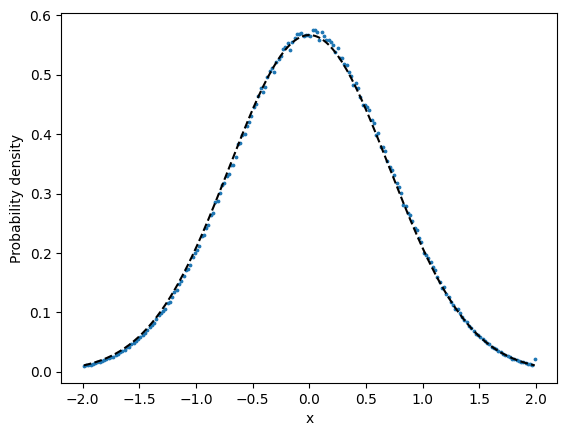

In [6]:
# Generating Paths and calculating weight of each path
paths_prop = []
weights_prop = []
x_end_prop = []

for xN in x_endpoints_prop:
    for _ in range(numb_paths_prop):
        p = Pos_Gen_prop(x_0_prop, xN, steps_prop)
        S = action_harmonic_prop(p, times_prop, mass_prop)
        w = np.exp(-S)
        paths_prop.append(p)
        weights_prop.append(w)
        x_end_prop.append(xN)

paths_prop = np.array(paths_prop)
weights_prop = np.array(weights_prop)
x_end_prop = np.array(x_end_prop)

print(paths_prop[0])
print(len(paths_prop))
print(len(paths_prop))
print(paths_prop[999:1001])

# Finding the groundstate wave function of the path
x_bins_prop = np.linspace(-2, 2, 201)

pdf_unnormalised_prop, bin_edges_prop = np.histogram(x_end_prop, bins=x_bins_prop, weights=weights_prop)
x_centres_prop = 0.5 * (bin_edges_prop[1:] + bin_edges_prop[:-1])
dx_prop = np.diff(x_bins_prop)[0]

# normalize to integrate to 0.5 (since we only use x > 0)
area_prop = np.sum(pdf_unnormalised_prop * dx_prop)
pdf_prop = pdf_unnormalised_prop / (area_prop)

# --- Analytic PDF for comparison (half side only) ---
phi_sq_analytic_prop = (1 / np.sqrt(np.pi)) * np.exp(-x_centres_prop ** 2)
phi_sq_analytic_prop /= np.sum(phi_sq_analytic_prop * dx_prop)  # normalize area to 0.5

# --- Check areas ---
print(f"Numerical PDF area: {np.sum(pdf_prop * dx_prop):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic_prop * dx_prop):.5f}")

plt.figure(1)
plt.scatter(x_centres_prop, pdf_prop, label='Path integral estimate', s=3)
plt.plot(x_centres_prop, phi_sq_analytic_prop, 'k--', label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.show()

# Metropolis Data

Thermalizing...


Thermalising:  36%|███▌      | 180/500 [00:00<00:00, 980.71it/s] 

Endpoint acceptance ≈ 0.533
Endpoint acceptance ≈ 0.496


Thermalising:  80%|████████  | 400/500 [00:00<00:00, 983.54it/s] 

Endpoint acceptance ≈ 0.525
Endpoint acceptance ≈ 0.533


Thermalising: 100%|██████████| 500/500 [00:00<00:00, 965.36it/s] 


Endpoint acceptance ≈ 0.525

Sampling...


Sampling:   2%|▏         | 104/5000 [00:00<00:05, 937.69it/s] 

Endpoint acceptance ≈ 0.535
Endpoint acceptance ≈ 0.511


Endpoint acceptance ≈ 0.522
Endpoint acceptance ≈ 0.508


Sampling:  12%|█▏        | 605/5000 [00:00<00:04, 984.47it/s] 

Endpoint acceptance ≈ 0.511
Endpoint acceptance ≈ 0.530
Endpoint acceptance ≈ 0.512


Sampling:  18%|█▊        | 907/5000 [00:00<00:04, 903.41it/s] 

Endpoint acceptance ≈ 0.535
Endpoint acceptance ≈ 0.499
Endpoint acceptance ≈ 0.537


Sampling:  24%|██▍       | 1209/5000 [00:01<00:03, 1031.70it/s]

Endpoint acceptance ≈ 0.507
Endpoint acceptance ≈ 0.515
Endpoint acceptance ≈ 0.531


Sampling:  30%|██▉       | 1487/5000 [00:01<00:03, 1094.53it/s]

Endpoint acceptance ≈ 0.549
Endpoint acceptance ≈ 0.545


Sampling:  34%|███▍      | 1704/5000 [00:01<00:03, 902.26it/s] 

Endpoint acceptance ≈ 0.527
Endpoint acceptance ≈ 0.505
Endpoint acceptance ≈ 0.541


Sampling:  40%|████      | 2004/5000 [00:02<00:03, 934.62it/s] 

Endpoint acceptance ≈ 0.548
Endpoint acceptance ≈ 0.540
Endpoint acceptance ≈ 0.515


Sampling:  46%|████▌     | 2306/5000 [00:02<00:02, 975.97it/s] 

Endpoint acceptance ≈ 0.540
Endpoint acceptance ≈ 0.546
Endpoint acceptance ≈ 0.529


Sampling:  52%|█████▏    | 2607/5000 [00:02<00:02, 964.50it/s] 

Endpoint acceptance ≈ 0.514
Endpoint acceptance ≈ 0.530
Endpoint acceptance ≈ 0.520


Sampling:  58%|█████▊    | 2906/5000 [00:02<00:02, 1044.73it/s]

Endpoint acceptance ≈ 0.516
Endpoint acceptance ≈ 0.528
Endpoint acceptance ≈ 0.533


Sampling:  64%|██████▍   | 3207/5000 [00:03<00:01, 918.48it/s] 

Endpoint acceptance ≈ 0.521
Endpoint acceptance ≈ 0.482
Endpoint acceptance ≈ 0.515


Sampling:  70%|███████   | 3500/5000 [00:03<00:01, 1110.97it/s]

Endpoint acceptance ≈ 0.532
Endpoint acceptance ≈ 0.542


Sampling:  74%|███████▍  | 3704/5000 [00:03<00:01, 897.49it/s] 

Endpoint acceptance ≈ 0.503
Endpoint acceptance ≈ 0.549
Endpoint acceptance ≈ 0.523


Sampling:  80%|████████  | 4013/5000 [00:03<00:00, 1086.95it/s]

Endpoint acceptance ≈ 0.530
Endpoint acceptance ≈ 0.543
Endpoint acceptance ≈ 0.504


Sampling:  86%|████████▌ | 4309/5000 [00:04<00:00, 1076.50it/s]

Endpoint acceptance ≈ 0.510
Endpoint acceptance ≈ 0.504
Endpoint acceptance ≈ 0.531


Sampling:  92%|█████████▏| 4588/5000 [00:04<00:00, 1153.97it/s]

Endpoint acceptance ≈ 0.537
Endpoint acceptance ≈ 0.540


Sampling:  96%|█████████▌| 4810/5000 [00:04<00:00, 1027.75it/s]

Endpoint acceptance ≈ 0.505
Endpoint acceptance ≈ 0.527
Endpoint acceptance ≈ 0.517


Sampling: 100%|██████████| 5000/5000 [00:04<00:00, 1007.98it/s]


Endpoint acceptance ≈ 0.515

------ Results ------
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000
Standard deviation: 0.7200 (expected ≈ 0.707)
Root mean square: 0.7201 (expected ≈ 0.707)


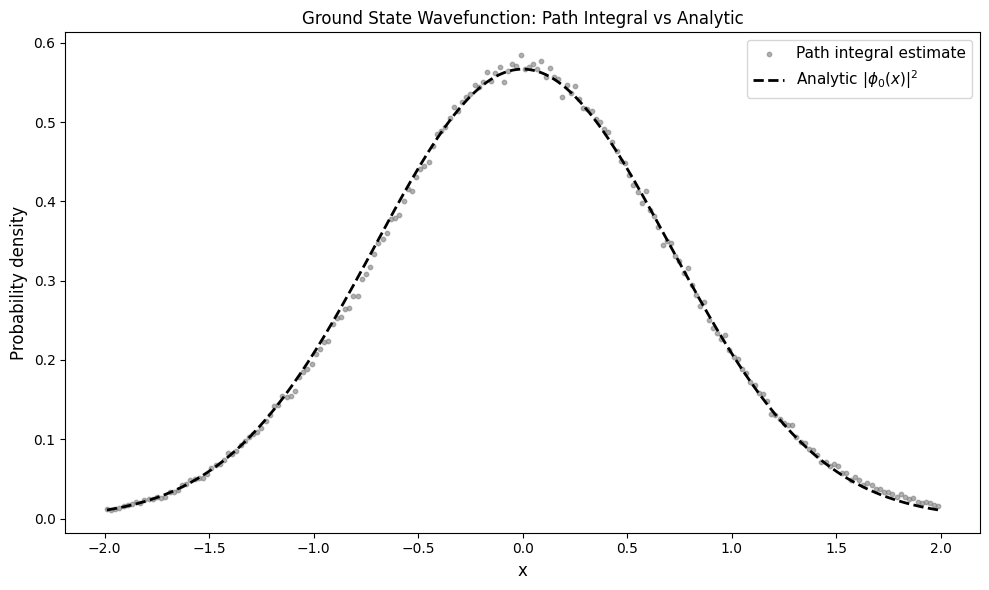

In [9]:
paths_x = np.array([
    MA.Pos_Gen(0.0, 0.0, steps, dt)
    for _ in range(numb_paths)
])

paths_orig = paths_x.copy()
C = 1.8437008005694266
mid = paths_x.shape[1] // 2
thin = 10
sigma_prop = C * np.sqrt(dt)

# Thermalization
print("Thermalizing...")
for sweep in trange(500, desc="Thermalising", mininterval=0):
    acceptances, endpoint_accept = MA.metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if sweep % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

# Sampling
print("\nSampling...")
samples_x = []

for k in trange(5000, desc="Sampling", mininterval=0):
    acceptances, endpoint_accept = MA.metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if k % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

    if k % thin == 0:
        samples_x.append(paths_x[:, -1].copy())

samples_x = np.concatenate(samples_x)

# Compute PDF
x_bins = np.linspace(-2, 2, 201)
pdf_unnormalised_x, bin_edges_x = np.histogram(samples_x, bins=x_bins)

x_centres = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])
dx = np.diff(x_bins)[0]

pdf_x = pdf_unnormalised_x / np.sum(pdf_unnormalised_x * dx)

# Analytic PDF
phi_sq_analytic_x = (1 / np.sqrt(np.pi)) * np.exp(-x_centres ** 2)
phi_sq_analytic_x /= np.sum(phi_sq_analytic_x * dx)

# Statistics
mean_square_x = np.mean(samples_x ** 2)
rms = np.sqrt(mean_square_x)
std = np.std(samples_x)

print("\n------ Results ------")
print(f"Numerical PDF area: {np.sum(pdf_x * dx):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic_x * dx):.5f}")
print(f"Standard deviation: {std:.4f} (expected ≈ 0.707)")
print(f"Root mean square: {rms:.4f} (expected ≈ 0.707)")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x_centres, pdf_x, label='Path integral estimate', s=10, alpha=0.6, color='grey')
plt.plot(x_centres, phi_sq_analytic_x, 'black', linestyle='--', linewidth=2, label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x', fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.legend(fontsize=11)
plt.title('Ground State Wavefunction: Path Integral vs Analytic')

plt.tight_layout()
plt.show()

# Bootstrapping

In [87]:
def chi_squared(model_params, model, x_data, y_data, y_err):
    residuals = (y_data - model(x_data, *model_params)) / y_err
    chi2 = np.sum(residuals**2)
    return chi2


def gaussian_model(x,A,B):
    return A*np.exp(B*x**2)

In [90]:
#Bootstrapping Metropolis

from tqdm.auto import trange
import numpy as np

def metropolis_pdf_bootstrap(
    n_bootstraps,
    numb_paths,
    steps,
    dt,
    times,
    mass,
    x_potential,
    sigma_prop,
    x_bins,
    n_therm=500,
    n_sample=5000,
    thin=10,
):

    dx = np.diff(x_bins)[0]
    x_centres = 0.5 * (x_bins[1:] + x_bins[:-1])

    pdfs = []

    for b in trange(n_bootstraps, desc="Bootstrap runs"):
        # --- fresh paths ---
        paths_x = np.array([
            MA.Pos_Gen(0.0, 0.0, steps, dt)
            for _ in range(numb_paths)
        ])

        # --- thermalisation ---
        for _ in range(n_therm):
            MA.metropolis_sweep_vectorised(
                paths_x, times, mass, x_potential, sigma_prop
            )

        # --- sampling ---
        samples_x = []

        for k in range(n_sample):
            MA.metropolis_sweep_vectorised(
                paths_x, times, mass, x_potential, sigma_prop
            )

            if k % thin == 0:
                samples_x.append(paths_x[:, -1].copy())

        samples_x = np.concatenate(samples_x)

        # --- PDF ---
        hist, _ = np.histogram(samples_x, bins=x_bins)
        pdf = hist / np.sum(hist * dx)

        pdfs.append(pdf)

    pdfs = np.array(pdfs)

    # --- statistics across runs ---
    pdf_mean = np.mean(pdfs, axis=0)
    pdf_se   = np.std(pdfs, axis=0, ddof=1) / np.sqrt(n_bootstraps)

    return x_centres, pdf_mean, pdf_se

def bootstrap_propagator_pdf(
    x_end_prop,
    weights_prop,
    x_bins_prop,
    n_bootstrap=1000
):
    """
    Bootstrap the propagator PDF from weighted paths.

    Returns:
        x_centres: array
        pdf_mean: array
        pdf_se: array
    """
    dx = np.diff(x_bins_prop)[0]
    x_centres = 0.5 * (x_bins_prop[1:] + x_bins_prop[:-1])

    pdfs = []

    n_paths = len(x_end_prop)
    for _ in trange(n_bootstrap, desc="Bootstrap propagator"):
        # Resample indices with replacement
        indices = np.random.choice(n_paths, size=n_paths, replace=True)
        x_resample = x_end_prop[indices]
        w_resample = weights_prop[indices]

        # Weighted histogram
        hist, _ = np.histogram(x_resample, bins=x_bins_prop, weights=w_resample)
        pdf = hist / np.sum(hist * dx)
        pdfs.append(pdf)

    pdfs = np.array(pdfs)
    pdf_mean = np.mean(pdfs, axis=0)
    pdf_se   = np.std(pdfs, axis=0, ddof=1)

    return x_centres, pdf_mean, pdf_se


In [70]:
x_bins = np.linspace(-2, 2, 201)

x_centres, pdf_mean, pdf_se = metropolis_pdf_bootstrap(
    n_bootstraps=100,
    numb_paths=numb_paths,
    steps=steps,
    dt=dt,
    times=times,
    mass=mass,
    x_potential=x_potential,
    sigma_prop=sigma_prop,
    x_bins=x_bins,
    n_therm=500,
    n_sample=5000,
    thin=10,
)

Bootstrap runs: 100%|██████████| 100/100 [03:46<00:00,  2.27s/it]


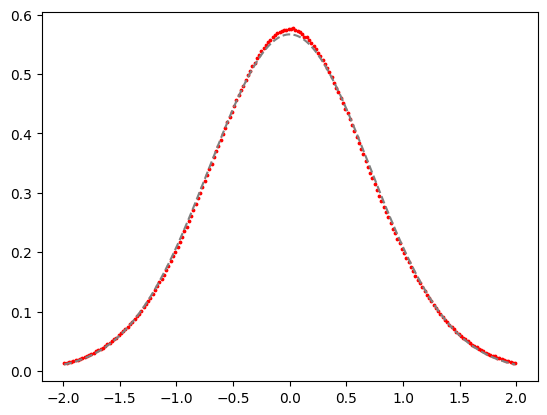

In [72]:
plt.figure(1)
plt.scatter(x_centres, pdf_mean, s = 3, color = "red")
plt.plot(x_centres, phi_sq_analytic_x, 'grey', linestyle = "--")
plt.show()

In [91]:
x_centres_prop_boot, pdf_mean_prop, pdf_se_prop = bootstrap_propagator_pdf(
    x_end_prop,
    weights_prop,
    x_bins_prop,
    n_bootstrap=500  # tune as desired
)


Bootstrap propagator: 100%|██████████| 500/500 [00:02<00:00, 218.16it/s]


In [92]:
#residuals for propagator

propagator_residuals_normalised = (pdf_mean_prop - phi_sq_analytic_x)/pdf_se_prop
print(np.std(propagator_residuals_normalised))

#residuals for metropolis

metropolis_residiuals_normalised = (pdf_mean - phi_sq_analytic_x)/pdf_se
print(np.std(metropolis_residiuals_normalised))

1.5049003742352793
4.933807228995433


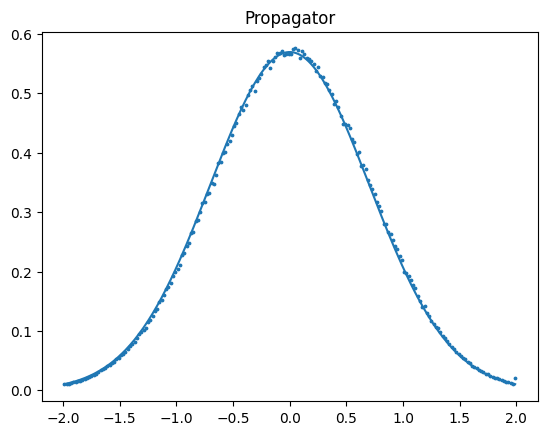

----- Propagator -----
A = 0.570 ± 0.000
B = -1.012 ± 0.000
Red_chi2 = 2.1108
----- ----- ----- -----


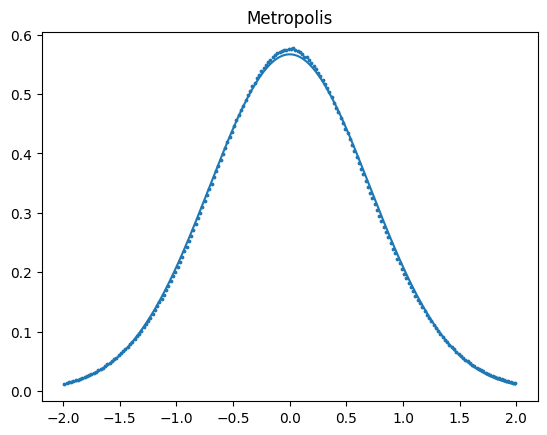

----- Metropolis -----
A = 0.567 ± 0.000
B = -0.998 ± 0.000
Red_chi2 = 25.1995
----- ----- ----- -----


In [93]:
# goodness of fit testing
p0_gaussian = [0.505,1]

popt_prop, cov_prop = curve_fit(gaussian_model,
                                x_centres,
                                pdf_prop,
                                sigma = pdf_se_prop,
                                absolute_sigma = True,
                                p0 = p0_gaussian)

popt_metrop, cov_metrop = curve_fit(gaussian_model,
                                    x_centres,
                                    pdf_mean,
                                    sigma = pdf_se,
                                    absolute_sigma= True,
                                    p0 = p0_gaussian)

chi2_metrop = chi_squared(
    popt_metrop,
    gaussian_model,
    x_data=x_centres,
    y_data=pdf_mean,
    y_err=pdf_se
)
dof_metrop = len(x_centres) - len(popt_metrop)

red_chi2_metrop = chi2_metrop/dof_metrop

chi2_prop = chi_squared(
    popt_prop,
    gaussian_model,
    x_data=x_centres,
    y_data=pdf_mean_prop,
    y_err=pdf_se_prop
)
dof_prop = len(x_centres) - len(popt_prop)

red_chi2_prop = chi2_prop/dof_prop

plt.figure(1)
plt.title("Propagator")
plt.scatter(x_centres,pdf_prop, s =3)
plt.plot(x_centres,gaussian_model(x_centres,*popt_prop))
plt.show()
print(f"----- Propagator -----")
print(f"A = {popt_prop[0]:.3f} ± {np.std(cov_prop[0][0]):.3f}")
print(f"B = {popt_prop[1]:.3f} ± {np.std(cov_prop[1][1]):.3f}")
print(f"Red_chi2 = {red_chi2_prop:.4f}")
print(f"----- ----- ----- -----")

plt.figure(2)
plt.title("Metropolis")
plt.scatter(x_centres,pdf_mean, s =3)
plt.plot(x_centres,gaussian_model(x_centres,*popt_metrop))
plt.show()
print(f"----- Metropolis -----")
print(f"A = {popt_metrop[0]:.3f} ± {np.std(cov_metrop[0][0]):.3f}")
print(f"B = {popt_metrop[1]:.3f} ± {np.std(cov_metrop[1][1]):.3f}")
print(f"Red_chi2 = {red_chi2_metrop:.4f}")
print(f"----- ----- ----- -----")

# Other shit Im not sure about

In [46]:
def model_pdf(x, B, dx):
    unnorm = np.exp(B * x**2)
    A = 1.0 / np.sum(unnorm * dx)
    return A * unnorm

def neg_log_likelihood(B, x, pdf_data, dx):
    pdf_model = model_pdf(x, B, dx)

    mask = pdf_data > 0
    return np.sum(
        pdf_data[mask] * np.log(pdf_data[mask] / pdf_model[mask])
    ) * dx


In [30]:
#model fitting

from scipy.optimize import minimize

dx = x_centres[1] - x_centres[0]

res_prop = minimize(
    neg_log_likelihood,
    x0=-1.0,
    args=(x_centres, pdf_prop, dx)
)

res_metro = minimize(
    neg_log_likelihood,
    x0=-1.0,
    args=(x_centres, pdf_x, dx)
)

B_prop = res_prop.x[0]
B_metro = res_metro.x[0]

print(f"B (propagator) = {B_prop:.6f}")
print(f"B (metropolis) = {B_metro:.6f}")


B (propagator) = -1.012434
B (metropolis) = -0.982662


In [31]:
def bootstrap_B(x, pdf, dx, n_boot=500):
    Bs = []
    for _ in range(n_boot):
        noise = np.random.normal(0, np.sqrt(pdf / np.sum(pdf)), size=pdf.size)
        pdf_boot = pdf + noise
        pdf_boot = np.clip(pdf_boot, 0, None)
        pdf_boot /= np.sum(pdf_boot * dx)

        res = minimize(
            neg_log_likelihood,
            x0=-1.0,
            args=(x, pdf_boot, dx)
        )
        Bs.append(res.x[0])
    return np.array(Bs)

Bs_prop = bootstrap_B(x_centres, pdf_prop, dx)
Bs_metro = bootstrap_B(x_centres, pdf_x, dx)

print("Propagator: ", Bs_prop.mean(), Bs_prop.std())
print("Metropolis: ", Bs_metro.mean(), Bs_metro.std())


Propagator:  -1.0028614874023436 0.030042857776806042
Metropolis:  -0.9745729221969635 0.029707850982850503


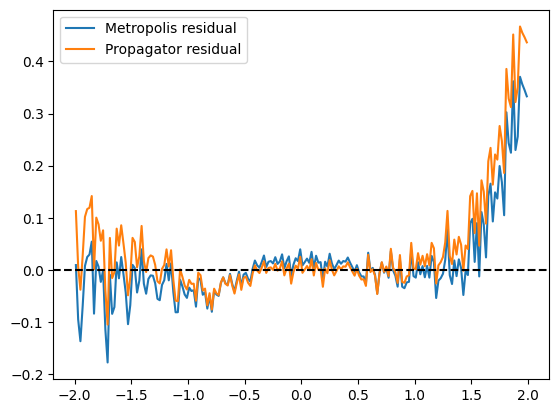

In [34]:
KL_prop = neg_log_likelihood(B_prop, x_centres, pdf_prop, dx)
KL_metro = neg_log_likelihood(B_metro, x_centres, pdf_x, dx)

plt.plot(
    x_centres,
    np.log(pdf_x) - np.log(model_pdf(x_centres, B_metro, dx)),
    label="Metropolis residual"
)
plt.plot(
    x_centres,
    np.log(pdf_x) - np.log(model_pdf(x_centres, B_prop, dx)),
    label="Propagator residual"
)
plt.axhline(0, color='k', ls='--')
plt.legend()


Bootstrapping: 100%|██████████| 1000/1000 [02:53<00:00,  5.75it/s]


B = -0.964090
σ_B = 0.002023
68% CI = [-0.966113, -0.962109]


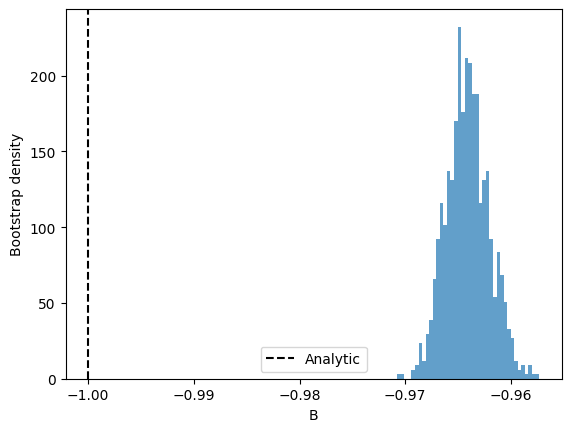

In [39]:
def neg_log_likelihood_raw(B, samples):
    # evaluate model on the samples themselves
    pdf_vals = np.exp(B * samples**2)

    # normalisation constant
    # (compute on a fine grid for stability)
    x_grid = np.linspace(-5, 5, 4001)
    Z = np.trapezoid(np.exp(B * x_grid**2), x_grid)

    return -np.sum(np.log(pdf_vals / Z))

def bootstrap_B_raw(samples, n_boot=1000):
    N = len(samples)
    B_boot = np.empty(n_boot)

    for i in trange(n_boot, desc="Bootstrapping"):
        # resample with replacement
        boot_samples = np.random.choice(samples, size=N, replace=True)

        res = minimize(
            neg_log_likelihood_raw,
            x0=-1.0,
            args=(boot_samples,),
            method="Nelder-Mead"
        )

        B_boot[i] = res.x[0]

    return B_boot

B_boot = bootstrap_B_raw(samples_x, n_boot=1000)

B_mean = np.mean(B_boot)
B_std  = np.std(B_boot)
B_ci   = np.percentile(B_boot, [16, 84])

print(f"B = {B_mean:.6f}")
print(f"σ_B = {B_std:.6f}")
print(f"68% CI = [{B_ci[0]:.6f}, {B_ci[1]:.6f}]")

plt.hist(B_boot, bins=40, density=True, alpha=0.7)
plt.axvline(-1, color='k', ls='--', label='Analytic')
plt.xlabel("B")
plt.ylabel("Bootstrap density")
plt.legend()
plt.show()


# Main Plot

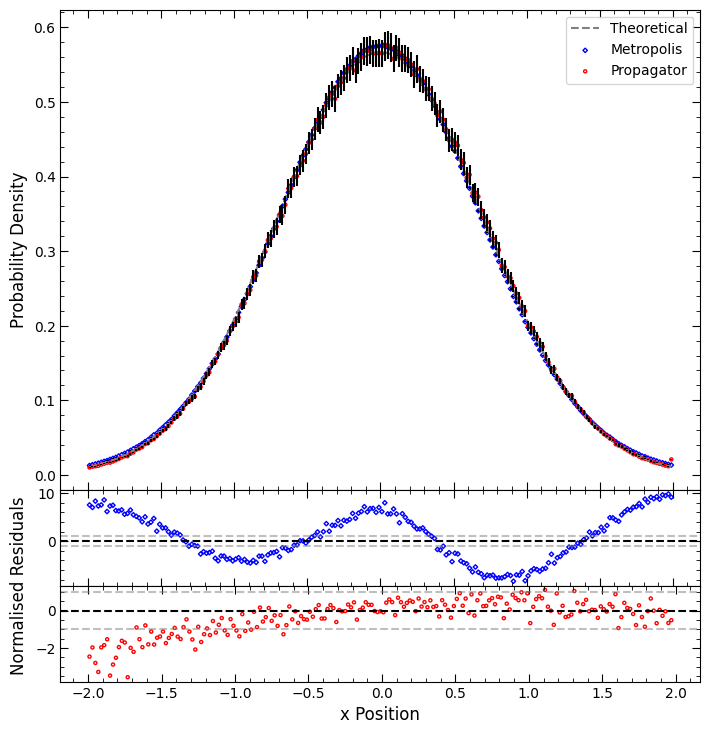

In [96]:
#plot
laptop_savepath_main_results = r"C:\Users\sebas\Documents\Durham Work\Year 3\Comp Phys\main_results.svg"

fig = plt.figure(1)

#main plot
fig.add_axes([0,0,1,1])
plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

plt.plot(x_centres, phi_sq_analytic_x, linestyle = "--", color = "grey", label = "Theoretical")

plt.scatter(x_centres, pdf_mean, marker = "D", s = 5,color = "blue", facecolor = "none", label = "Metropolis")
plt.errorbar(x_centres, pdf_mean, yerr= pdf_se, linestyle = "none", color = "black")

plt.scatter(x_centres, pdf_mean_prop, marker = "o", s = 5, color = "red", facecolor = "none", label = "Propagator")
plt.errorbar(x_centres, pdf_mean_prop, yerr = pdf_se_prop, linestyle = "none", color = "black")

plt.legend()
plt.ylabel("Probability Density", fontsize=12)


#residual plot 1
rp1 = fig.add_axes(([0,-0.2,1,0.2]))
plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

rp1.axhline(0, color = 'black', linestyle = '--')
rp1.axhline(1, color = 'grey', linestyle = '--',alpha = 0.5)
rp1.axhline(-1, color = 'grey', linestyle = '--',alpha = 0.5)

plt.scatter(x_centres, metropolis_residiuals_normalised, marker = "D", s = 5,color = "blue", facecolor = "none")


#residual plot 2
rp2 = fig.add_axes(([0,-0.4,1,0.2]))
plt.minorticks_on()
plt.tick_params(which = 'major', length = 6, bottom = True, top = True, left = True, right = True, direction = 'in')
plt.tick_params(which = 'minor', length = 3, bottom = True, top = True, left = True, right = True, direction = 'in')

rp2.axhline(0, color = 'black', linestyle = '--')
rp2.axhline(1, color = 'grey', linestyle = '--',alpha = 0.5)
rp2.axhline(-1, color = 'grey', linestyle = '--',alpha = 0.5)

plt.scatter(x_centres[0:199], propagator_residuals_normalised[0:199], marker = "o", s = 5, color = "red", facecolor = "none")

plt.xlabel("x Position", fontsize=12)
rp2.set_ylabel("Normalised Residuals",fontsize=12)
rp2.yaxis.set_label_coords(-0.05,1)

plt.savefig(laptop_savepath_main_results, bbox_inches = 'tight')
plt.show()

199
199


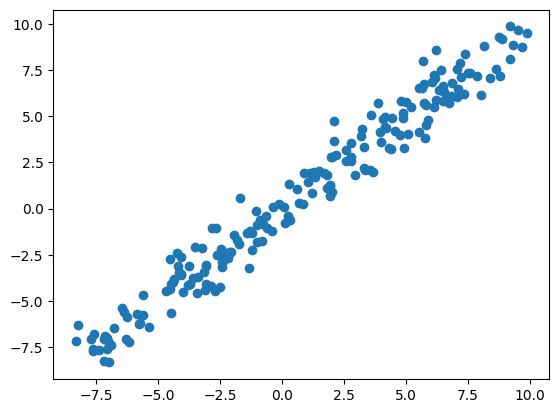

In [80]:
# lag plots

metropolis_ith = metropolis_residiuals_normalised[1:]
print(len(metropolis_ith))
metropolis_i_minus_one = metropolis_residiuals_normalised[0:199]
print(len(metropolis_i_minus_one))

plt.figure(1)
plt.scatter(metropolis_ith,metropolis_i_minus_one)

plt.show()

199
199


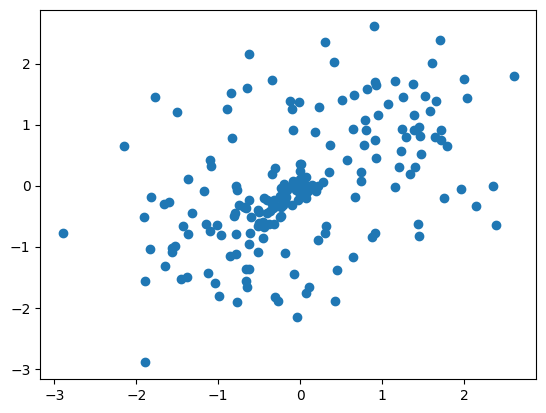

In [81]:
propagator_ith = propagator_residuals_normalised[1:]
print(len(propagator_ith))
propagator_i_minus_one = propagator_residuals_normalised[0:199]
print(len(propagator_i_minus_one))

plt.figure(1)
plt.scatter(propagator_ith,propagator_i_minus_one)

plt.show()